# Spam detector with LSTM and NLP

In [150]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Download the dataset

In [151]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File 'spam.csv' already there; not retrieving.



In [152]:
%%bash
head -n5 spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,


In [153]:
# Load in the data as a dataframe
df = pd.read_csv("spam.csv", usecols=[0, 1], encoding="ISO-8859-1")

In [154]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [155]:
# Convert the labels to numbers
targets = df["v1"].map({"ham":0, "spam":1}).to_numpy().reshape(-1, 1)
targets[:5]

array([[0],
       [0],
       [1],
       [0],
       [0]], dtype=int64)

In [156]:
# Split the data
df_train, df_test, y_train, y_test = train_test_split(df, targets, test_size=0.2)
y_train.shape, y_test.shape

((4457, 1), (1115, 1))

In [ ]:
# Tokenize and "index" the documents
word2int = {"<unk>":0, "<pad>":1}
idx = 2
X_train, X_test = [], []
for row in df_train["v2"]:
    tokens = word_tokenize(row)
    for token in tokens:
        if word2int.setdefault(token, idx) == idx:
            idx += 1
    X_train.append(list(map(lambda w: word2int[w], tokens)))

# Encode the test set
for row in df_test["v2"]:
    tokens = word_tokenize(row)
    sent = []
    for token in tokens:
        sent.append(word2int.get(token, word2int["<unk>"]))
    X_test.append(sent)

In [158]:
len(word2int)

10153

## Data generator

In [167]:
def data_generator(X, y, batch_size=32):
    X, y = shuffle(X, y)
    num_batches = int(np.ceil(len(y) / batch_size))
    for idx in range(num_batches):
        # Grad each batch
        end = min(len(y), (idx + 1) * batch_size)
        X_batch, y_batch = X[idx*batch_size:end], y[idx*batch_size:end]
        
        # Handle padding (pre-padding)
        max_len = len(max(X_batch, key=len))
        for i in range(len(X_batch)):
            X_batch[i] = [word2int["<pad>"]] * (max_len - len(X_batch[i])) + X_batch[i]
        
        # Convert to torch Tensor
        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(y_batch).long()
        
        yield X_batch, y_batch

## Build the model

In [160]:
class LSTM_Classifier(nn.Module):
    def __init__(self, num_vocab, embed_dim, num_outs, num_hiddens, num_layers):
        super(LSTM_Classifier, self).__init__()
        
        self.V = num_vocab
        self.D = embed_dim
        self.L = num_layers
        self.K = num_outs
        self.M = num_hiddens
        
        # Encoding layer
        self.emb = nn.Embedding(self.V, self.D)
        
        # RNN layer
        self.lstm = nn.LSTM(self.D, self.M, self.L, batch_first=True)
        
        # Dense layer
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        # Initial states for rnn layer
        h0 = torch.zeros(self.L, X.size(0), self.M)
        c0 = torch.zeros(self.L, X.size(0), self.M)
        # Encode the sentences
        out = self.emb(X)

        # RNN magic
        out, _ = self.lstm(out, (h0, c0))
        
        # max pooling (the max value hidden time stamp is kept)
        out, _ = torch.max(out, 1)
        
        # Linear layer
        out = self.fc(out)
        return out

In [161]:
def configure(model, lr, optim_method):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) if optim_method == 'adam' else optim.SGD(model.parameters(), lr=lr)
    return criterion, optimizer

In [162]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, num_epochs):
    loss_history, test_history = np.zeros(num_epochs), np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        # Training
        train_loss = []
        for inputs, targets in train_loader():
            optimizer.zero_grad()
            
            # Forward pass
            outs = model(inputs)
            loss = criterion(outs, targets.float())
            train_loss.append(loss.item())
            
            # Update params
            loss.backward()
            optimizer.step()
        # Record the loss
        loss_history[epoch] = np.mean(train_loss)
        
        # Validating
        test_loss = []
        for inputs, targets in test_loader():
            outs = model(inputs)
            loss = criterion(outs, targets.float())
            test_loss.append(loss.item())
        test_history[epoch] = np.mean(test_loss)
    
    return loss_history, test_history

## Train the model

In [180]:
# Hyperparameters
embed_dim = 20
num_hiddens = 15
lr = 0.001
num_epochs = 15
optim_method = 'adam'

In [181]:
model = LSTM_Classifier(len(word2int), embed_dim, 1, num_hiddens, 1)
criterion, optimizer = configure(model, lr, optim_method)

In [173]:
train_loader = lambda: data_generator(X_train, y_train)
test_loader = lambda: data_generator(X_test, y_test)

In [182]:
# Train
loss_history, test_history = batch_gd(model, criterion, optimizer, train_loader, test_loader, num_epochs)

## Evaluate the model

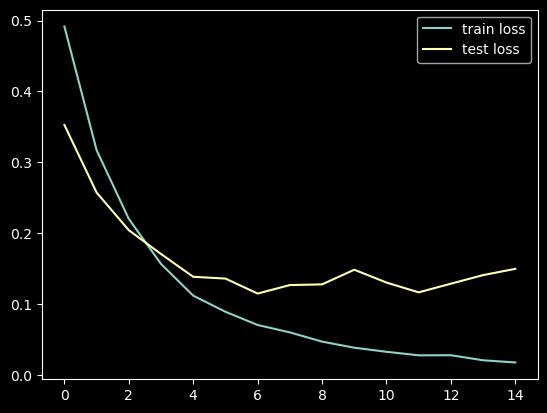

In [183]:
# Plot the loss over time
plt.plot(loss_history, label="train loss")
plt.plot(test_history, label="test loss")
plt.legend()
plt.show()

In [201]:
# Accuracy
def compute_accuracy(model, data_loader):
    n_correct, n_total = 0, 0
    for inputs, targets in data_loader():
        outs = model(inputs)
        preds = (outs > 0)
        n_correct += (preds == targets).sum().item()
        n_total += targets.shape[0]
    return n_correct / n_total

In [202]:
compute_accuracy(model, train_loader), compute_accuracy(model, test_loader)

(0.9961857751851021, 0.9668161434977578)